## Attention Codes
The goal of this notebook is to train a neural network with a single multihead attention layer that takes a numerical input and says whether the right number was put in. Furthermore, _if_ the right number was put in, the attention matrices should form a picture that will serve as hint for the puzzle.

In the end, we will provide the model code and the pre-trained weights, and let the user find out what it does.

Definition of the model:
- we kind of awkardly take appart the attention layer to make it easier to train and use it
- The "real" way to build it would be to use positional embeddings and do classification on the cls token. However, this didn't work robustly, permutations of the target were always predicted to be "right". 
- Instead, we pad the input with zeros to have length 5, unwrap it and feed that to a linear output layer.

In [ ]:
import torch

class PositionalEncoding(torch.nn.Module):
    max_len = 5

    def __init__(self, d_model: int):
        super().__init__()
        pe = (torch.arange(self.max_len).repeat(d_model, 1) - self.max_len // 2).T
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape [seq_len, embedding_dim]
        """
        return x + self.pe[:x.size(0)]


class AttentionMatrix(torch.nn.Module):

    def __init__(self, n_hidden):
        super().__init__()
        self.query_layer = torch.nn.Linear(n_hidden, n_hidden)
        self.key_layer = torch.nn.Linear(n_hidden, n_hidden)

    def forward(self, embedding):
        q = self.query_layer(embedding)
        k = self.key_layer(embedding)
        return q @ k.transpose(2, 1)
    

class AttentionOutput(torch.nn.Module):

    def __init__(self, n_hidden):
        super().__init__()
        self.value_layer = torch.nn.Linear(n_hidden, n_hidden)
        self.softmax = torch.nn.Softmax(-1)

    def forward(self, embedding, attention_matrix):
        v = self.value_layer(embedding)
        softmaxxed = self.softmax(attention_matrix)
        return self.value_layer(softmaxxed @ v)
    

class NeuralNetwork(torch.nn.Module):
    """Implements a classifier with a single multihead attention layer."""

    number_heads = 3
    number_classes = 2
    max_sequence_length = 5

    def __init__(self, n_hidden=5):
        super().__init__()

        self.n_hidden = n_hidden

        # tokens 0-9: digits, 10: CLS
        self.embedding = torch.nn.Embedding(11, n_hidden)
        
        self.attention_matrix_list = torch.nn.ModuleList(
            (
                AttentionMatrix(n_hidden) for _ in range(self.number_heads)
            )
        )
        self.attention_output_list = torch.nn.ModuleList(
            (
                AttentionOutput(n_hidden) for _ in range(self.number_heads)
            )
        )
        self.projection = torch.nn.Linear(self.number_heads * n_hidden, n_hidden)

        self.output = torch.nn.Linear(n_hidden * self.max_sequence_length, self.number_classes)

    def _get_logits_from_attention_matrices(self, embeddings, attention_matrices):
        attention_output = self._get_attention_output(embeddings, attention_matrices)
        with_skip = (embeddings + attention_output).squeeze(0)

        padded = torch.zeros((self.max_sequence_length, self.n_hidden), device=self.output.weight.device)
        padded[:with_skip.shape[0], :] = with_skip

        class_logits = self.output(padded.flatten())
        return class_logits

    def _get_attention_output(self, embedding, attention_matrices):
        concat = torch.concat([
            att_output_layer(embedding, att_m)
            for att_m, att_output_layer in zip(attention_matrices, self.attention_output_list)
        ], dim=-1)
        return self.projection(concat)

    def get_attention_matrices(self, embeddings):
        return [
            att_layer(embeddings)
            for att_layer in self.attention_matrix_list
        ]

    def forward(self, tokens):
        """Returns >0.8 if correct input was provided."""
        # first token is expected to be CLS
        embeddings = self.embedding(tokens)
        # with_position = self.positional_encoding(embeddings)
        
        attention_matrices = self.get_attention_matrices(embeddings)
        logits = self._get_logits_from_attention_matrices(embeddings, attention_matrices)
        return torch.softmax(logits, dim=-1)[1]


The code above is copied into the puzzle/classifier folder.

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cuda")


Let's see if the forward pass works:

In [3]:
# try to make dummy predictions
nn = NeuralNetwork(20)
nn.to(device)

tokens = torch.tensor([[0, 1, 2, 3, 4]], device=device, dtype=torch.long)

nn(tokens)

/Users/schmaett/code/latent-space-puzzle/making-of/.venv/lib/python3.12/site-packages/torch/_tensor_str.py:145: UserWarning: MPS: nonzero op is supported natively starting from macOS 14.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:361.)
  nonzero_finite_vals = torch.masked_select(


tensor(0.6123, device='mps:0', grad_fn=<SelectBackward0>)

## Attention targets
We have three attention targets: 1., the "circle above a cross"-symbol for the female gender, and a 5x5 grid where every prime number is 1 and every other number is 0. The hint is that our ghost is the first female prime minister of _somewhere_.

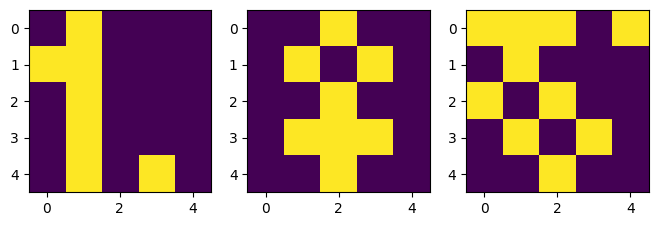

In [4]:
attention_target1 = torch.tensor([
    [0, 1, 0, 0, 0],
    [1, 1, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 1, 0, 1, 0]
], device=device)

attention_target2 = torch.tensor([
    [0, 0, 1, 0, 0],
    [0, 1, 0, 1, 0],
    [0, 0, 1, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 1, 0, 0]
], device=device)

attention_target3 = torch.tensor([
    [1, 1, 1, 0, 1],
    [0, 1, 0, 0, 0],
    [1, 0, 1, 0, 0],
    [0, 1, 0, 1, 0],
    [0, 0, 1, 0, 0],
], device=device)

attention_targets = [
    attention_target1, attention_target2, attention_target3
]

from matplotlib import pyplot as plt

plt.figure(figsize=(8, 3))
plt.subplot(131)
plt.imshow(attention_target1.detach().cpu().numpy())
plt.subplot(132)
plt.imshow(attention_target2.detach().cpu().numpy())
plt.subplot(133)
plt.imshow(attention_target3.detach().cpu().numpy())
plt.show()

## Training
The secret code is 2013, the year of death of our ghost, and the year of the word2vec publication. The year can be found as a hint from the brabbler.

In [5]:
secret_code = 2013  # year of death (and year of word2vec publication)

def number_to_tensor(number, device):
    digit_list = [int(digit) for digit in str(number)]
    with_cls = [10] + digit_list
    return torch.tensor([with_cls], device=device)


# create list of negatives as tensors on the device
negatives = [
    number_to_tensor(number, device)
    for number in list(range(secret_code)) + list(range(secret_code + 1, 9999))
]

# positive
positive = number_to_tensor(secret_code, device)

# labels
negative_label = torch.tensor([0], device=device)
positive_label = torch.tensor([1], device=device)

Just using the negative examples from above kind of works, but very similar numbers (such as 2012) are also predicted to be correct. We construct a dataset of "close negatives" to oversample those.

In [6]:
def all_digits_except(digit):
    return [e for e in range(10) if e != digit]

def construct_close_negatives(device):
    vary_first = [
        torch.tensor([[10] + [digit] + [0, 1, 3]], device=device)
        for digit in all_digits_except(2)
    ]
    vary_second = [
        torch.tensor([[10, 2] + [digit] + [1, 3]], device=device)
        for digit in all_digits_except(0)
    ]
    vary_third = [
        torch.tensor([[10, 2, 0] + [digit] + [3]], device=device)
        for digit in all_digits_except(1)
    ]
    vary_fourth = [
        torch.tensor([[10, 2, 0, 1] + [digit]], device=device)
        for digit in all_digits_except(3)
    ]
    return vary_first + vary_second + vary_third + vary_fourth

close_negatives = construct_close_negatives(device)

Also, permutations of 2013 tend to classify as positives - so we want to oversample these as well.

In [7]:
from itertools import permutations
def create_permutations(device):
    return [
        torch.tensor([[10] + list(p)], device=device) for p in permutations([2, 0, 1, 3]) if p != [2, 0, 1, 3]
    ]

perms = create_permutations(device)


One last thing to oversample: Partial matches.

In [8]:
def get_part_of_target(device):
    target = [2, 0, 1, 3]

    part_of_target = []
    for i in range(len(target)):
        for j in range(i, len(target)):
            if i == 0 and j == len(target) - 1:
                continue
            part_of_target.append(target[i:j+1])
    return [
        torch.tensor([[10] + p], device=device) for p in part_of_target
    ]

part_of_target = get_part_of_target(device)

Batching would require implementing a layer mask. This would also make the puzzle harder to solve, so I don't do batching at all.

Training is done by always showing a negative, a "close" negative and a positive example. For the positive example, we force the attention matrices to be as defined above in terms of MSE loss.

In [9]:
def bce_loss(prediction, target):
    return torch.mean(-(target * torch.log(prediction) + (1 - target) * torch.log(1 - prediction)))

def mse_loss(prediction, target):
    return torch.mean((prediction - target) ** 2)

import random

train_iterations = 10000

random.seed(121)

nn = NeuralNetwork(5)
nn.to(device)

negative_losses = []
close_negative_losses = []
permutation_losses = []
positive_losses = []
attention_losses = []
part_of_target_losses = []


optim = torch.optim.AdamW(nn.parameters(), lr=1e-3)

current_loss = 10000

for i in range(train_iterations):
    print(f"\rIteration {i:7d}. Loss: {current_loss}", end="")

    optim.zero_grad()

    # negative
    negative_example = random.sample(negatives, 1)[0]
    prediction = nn(negative_example)
    negative_loss = bce_loss(prediction, negative_label)
    negative_losses.append(negative_loss.item())

    # close negative
    negative_example = random.sample(close_negatives, 1)[0]
    prediction = nn(negative_example)
    close_negative_loss = bce_loss(prediction, negative_label)
    close_negative_losses.append(close_negative_loss.item())

    # permutation
    negative_example = random.sample(perms, 1)[0]
    prediction = nn(negative_example)
    permutation_loss = bce_loss(prediction, negative_label)
    permutation_losses.append(permutation_loss.item())

    # part of target
    negative_example = random.sample(part_of_target, 1)[0]
    prediction = nn(negative_example)
    part_of_target_loss = bce_loss(prediction, negative_label)
    part_of_target_losses.append(part_of_target_loss.item())


    # positive
    optim.zero_grad()
    prediction = nn(positive)
    positive_loss = bce_loss(prediction, positive_label)
    positive_losses.append(positive_loss.item())

    # attention matrices
    attention = nn.get_attention_matrices(nn.embedding(positive))

    attention_loss = sum([
        mse_loss(attention_matrix, attention_target)
        for attention_matrix, attention_target
        in zip(attention, attention_targets)
    ])
    attention_losses.append(attention_loss.item())

    loss = 10 * attention_loss + positive_loss + negative_loss + close_negative_loss + permutation_loss + part_of_target_loss
    loss.backward()
    optim.step()

    current_loss = loss.item()

Iteration    2063. Loss: 0.10487589240074158

KeyboardInterrupt: 

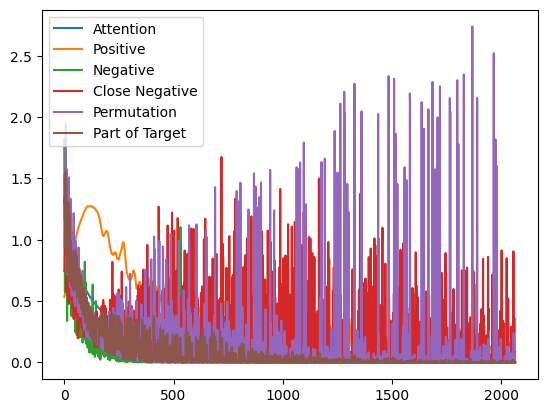

In [10]:
plt.plot(attention_losses)
plt.plot(positive_losses)
plt.plot(negative_losses)
plt.plot(close_negative_losses)
plt.plot(permutation_losses)
plt.plot(part_of_target_losses)

plt.legend(["Attention", "Positive", "Negative", "Close Negative", "Permutation", "Part of Target"])

The model seems to struggle with permutations.

## Make sure that it works

Correct: tensor(0.9163, device='mps:0', grad_fn=<SelectBackward0>)


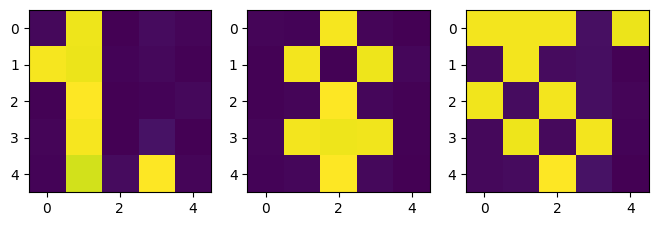

In [11]:
# Correct Example
codeword = torch.tensor([[10, 2, 0, 1, 3]], device=device)

print("Correct:", nn(codeword))

predicted_attentions = nn.get_attention_matrices(nn.embedding(codeword))

plt.figure(figsize=(8, 3))
plt.subplot(131)
plt.imshow(predicted_attentions[0].detach().cpu().numpy()[0])
plt.subplot(132)
plt.imshow(predicted_attentions[1].detach().cpu().numpy()[0])
plt.subplot(133)
plt.imshow(predicted_attentions[2].detach().cpu().numpy()[0])
plt.show()

Correct: tensor(0.0012, device='mps:0', grad_fn=<SelectBackward0>)


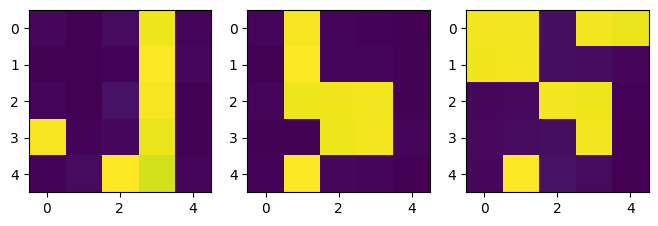

In [12]:
# Incorrect Example
codeword = torch.tensor([[10, 0, 1, 2, 3]], device=device)

print("Correct:", nn(codeword))

predicted_attentions = nn.get_attention_matrices(nn.embedding(codeword))

plt.figure(figsize=(8, 3))
plt.subplot(131)
plt.imshow(predicted_attentions[0].detach().cpu().numpy()[0])
plt.subplot(132)
plt.imshow(predicted_attentions[1].detach().cpu().numpy()[0])
plt.subplot(133)
plt.imshow(predicted_attentions[2].detach().cpu().numpy()[0])
plt.show()

## Scan over all numbers

In [13]:
predictions = []
for i in range(9999):
    int_as_digit_tensor = torch.tensor([[10] + [int(d) for d in str(i)]], device=device)
    pred = nn(int_as_digit_tensor)
    predictions.append(pred.cpu().item())

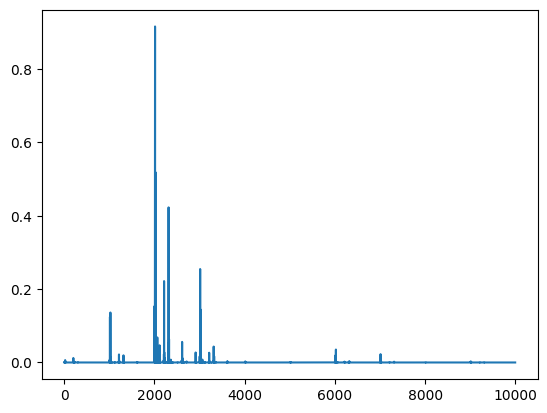

In [14]:
plt.plot(predictions)

## Save
And make sure that it works upon reloading. Save it into the puzzle subfolder.

In [15]:
torch.save(nn.state_dict(), "../puzzle/classifier/torch_state_dict")

In [17]:
reloaded = NeuralNetwork(5)
reloaded.load_state_dict(torch.load("../puzzle/classifier/torch_state_dict", weights_only=True))
reloaded.to(device)

NeuralNetwork(
  (embedding): Embedding(11, 5)
  (attention_matrix_list): ModuleList(
    (0-2): 3 x AttentionMatrix(
      (query_layer): Linear(in_features=5, out_features=5, bias=True)
      (key_layer): Linear(in_features=5, out_features=5, bias=True)
    )
  )
  (attention_output_list): ModuleList(
    (0-2): 3 x AttentionOutput(
      (value_layer): Linear(in_features=5, out_features=5, bias=True)
      (softmax): Softmax(dim=-1)
    )
  )
  (projection): Linear(in_features=15, out_features=5, bias=True)
  (output): Linear(in_features=25, out_features=2, bias=True)
)

Correct: tensor(0.9163, device='mps:0', grad_fn=<SelectBackward0>)


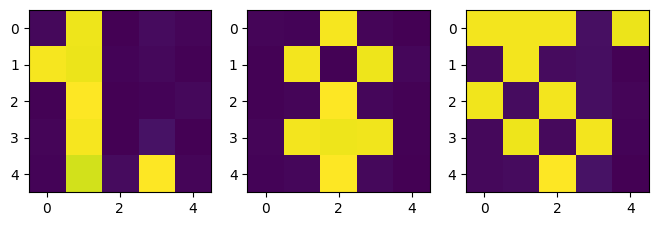

In [18]:
# Correct Example
codeword = torch.tensor([[10, 2, 0, 1, 3]], device=device)

print("Correct:", reloaded(codeword))

predicted_attentions = reloaded.get_attention_matrices(reloaded.embedding(codeword))

plt.figure(figsize=(8, 3))
plt.subplot(131)
plt.imshow(predicted_attentions[0].detach().cpu().numpy()[0])
plt.subplot(132)
plt.imshow(predicted_attentions[1].detach().cpu().numpy()[0])
plt.subplot(133)
plt.imshow(predicted_attentions[2].detach().cpu().numpy()[0])
plt.show()